In [1]:
import time
import numpy as np
from rebin import rebin #pip install rebin
import matplotlib.pyplot as plt
import random
import h5py
from libsx import *
import pickle

np.random.seed = 42

In [2]:
grav_const_in_cgs = G = 6.6738e-8
MSun = 1.98892e33  

Mcld = 1.0 * MSun                                     # The mass of the cloud
Rcld = 7.07e16                                     # The initial radius of the cloud in cm
omega = 2.12e-13                                 # The initial angular velocity of the cloud in radians s^-1 
rho0 = 1.35e-18                                 # The initial average density
cs = 1.9e4  # this corrsponds to mu = 2.28 in (kB * T_0 / mH2)**0.5 (mH2 = muu * mH)  # The sound speed

In [3]:
# Calculating derived quantities
tff = np.sqrt(3*np.pi/(32*G*rho0))                   # The free-fall time = 3.4e4 yr
tff_in_kyr = tff/3600/24/365.24/1000
print(f'tff in kyr = {tff_in_kyr:.2f}')

tff in kyr = 57.29


In [4]:
# Setting the units of the simulation
unitMass_in_g = MSun
unitLength_in_cm = Rcld
unitTime_in_s = (unitLength_in_cm**3/grav_const_in_cgs/unitMass_in_g)**0.5
unitVelocity_in_cm_per_s = unitLength_in_cm / unitTime_in_s

In [5]:
print(f'Unit_time_in_s = {round(unitTime_in_s, 2)} seconds')
print(f'Unit_time in kyrs = {round(unitTime_in_s/3600./24./365.25/1000., 2)} kyrs')
print(f'Unit_time in Myrs = {round(unitTime_in_s/3600./24./365.25/1e6, 4)} Myrs')

Unit_time_in_s = 1631675788861.21 seconds
Unit_time in kyrs = 51.7 kyrs
Unit_time in Myrs = 0.0517 Myrs


In [6]:
print(f'unitVelocity_in_cm_per_s = {round(unitVelocity_in_cm_per_s, 2)} cm/s')

unitVelocity_in_cm_per_s = 43329.69 cm/s


In [7]:
# calling things to code units
Rcld /= unitLength_in_cm
Mcld /= unitMass_in_g
omega *= unitTime_in_s

In [8]:
UnitDensity_in_cgs = unitMass_in_g / unitLength_in_cm**3
print(f'UnitDensity_in_cgs = {UnitDensity_in_cgs:.3E}')

UnitDensity_in_cgs = 5.628E-18


In [9]:
# Arreaga-García et al (2007)

Npart = 28000*2.40
L = 2.1 # Length of the cube. It is fine to get it a bit larger as we will constrain by r<=1.
V = L**3
delta = (V/Npart)**(1./3.)

print(f'delta = {delta:.4f}')

M = int(np.floor(L / delta))

print(f'M = {M}')

delta = 0.0517
M = 40


In [10]:
pos = []

for i in range(-M, M):
    for j in range(-M, M):
        for k in range(-M, M):
            
            xt, yt, zt = 0.0+i*delta, 0.0+j*delta, 0.0+k*delta
            
            rnd = np.random.random()
            if rnd > 0.5:
                sign = 1.0
            else:
                sign = -1.0
            
            # Adding some amount of disorder
            rnd = np.random.random()
            if rnd < 1./3.:
                xt += sign * delta/4.
            if (rnd >= 1./3.) & (rnd <= 2./3.):
                yt += sign * delta/4.
            if rnd > 2./3.:
                zt += sign * delta/4.
            
            r = (xt*xt + yt*yt + zt*zt)**0.5
            
            if r <= 1.0:
                pos.append([xt, yt, zt])

pos = np.array(pos)
print(pos.shape)

(30461, 3)


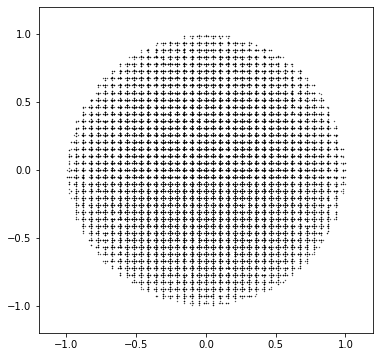

In [11]:
plt.figure(figsize = (6,6))
plt.scatter(pos[:, 0], pos[:, 1], s = 0.1, color = 'k')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2);

## Calculating particle velocities in rectangular coordinates

In [12]:
rxy = (pos[:,0]**2 + pos[:,1]**2)**0.5 
vel = np.zeros_like(pos)

vel[:,0] = -omega*pos[:,1]
vel[:,1] = omega*pos[:,0]

vel[:,2] = 0

wh = np.argwhere(np.isnan(vel)) # NaNs are handled here !
if len(wh) > 0:
    vel[wh] = 0.0


## Calculating particle masses

In [13]:
mp = Mcld / pos.shape[0]

# Imposing an m=2 density perturbation with an amplitude of 10 percent.
masses = mp * (1 + .1*((pos[:, 0]/rxy)**2 - (pos[:, 1]/rxy)**2))

wh = np.argwhere(np.isnan(masses)) # Fixes an issue with the particle at the origin
if len(wh) > 0:
    masses[wh] = mp

/tmp/ipykernel_70871/2343784876.py:4: RuntimeWarning: invalid value encountered in true_divide
  masses = mp * (1 + .1*((pos[:, 0]/rxy)**2 - (pos[:, 1]/rxy)**2))


In [14]:
# Assign particle sound speed (isothermal EOS)
u = np.zeros(len(masses)) + cs**2 / unitVelocity_in_cm_per_s**2

# IC for Gadget

In [15]:
#write intial conditions file

ids = np.arange(pos.shape[0])

FloatType = np.float32  # double precision: np.float64, for single use np.float32
IntType = np.int32

IC = h5py.File('hfv_ic.hdf5', 'w')

## create hdf5 groups
header = IC.create_group("Header")
part0 = IC.create_group("PartType0")

## header entries
NumPart = np.array([pos.shape[0]], dtype=IntType)
header.attrs.create("NumPart_ThisFile", NumPart)
header.attrs.create("NumPart_Total", NumPart)
header.attrs.create("NumPart_Total_HighWord", np.zeros(1, dtype=IntType) )
header.attrs.create("MassTable", np.zeros(1, dtype=IntType) )
header.attrs.create("Time", 0.0)
header.attrs.create("Redshift", 0.0)
header.attrs.create("BoxSize", 0)
header.attrs.create("NumFilesPerSnapshot", 1)
header.attrs.create("Omega0", 0.0)
header.attrs.create("OmegaB", 0.0)
header.attrs.create("OmegaLambda", 0.0)
header.attrs.create("HubbleParam", 1.0)
header.attrs.create("Flag_Sfr", 0)
header.attrs.create("Flag_Cooling", 0)
header.attrs.create("Flag_StellarAge", 0)
header.attrs.create("Flag_Metals", 0)
header.attrs.create("Flag_Feedback", 0)
if pos.dtype == np.float64:
    header.attrs.create("Flag_DoublePrecision", 1)
else:
    header.attrs.create("Flag_DoublePrecision", 0)

## copy datasets
part0.create_dataset("Coordinates", data=pos)
part0.create_dataset("Velocities", data=vel)
part0.create_dataset("ParticleIDs", data=ids )
part0.create_dataset("Masses", data=masses)
part0.create_dataset("InternalEnergy", data=u)

IC.close()

In [16]:
dictx = {'r': pos, 'v': vel, 'm': masses,
         'unitVelocity': unitVelocity_in_cm_per_s,
         'unitTime': unitTime_in_s,
         't_ff': tff}

num = str(int(np.floor(pos.shape[0]/1000)))

with open('tmp_hfv_IC_RND_' + num +'k.pkl', 'wb') as f:
    pickle.dump(dictx, f)

# Next Step: USE the `h_generator` script to complete IC creation !!

# Density profile

In [ ]:
h = do_smoothingX((pos, pos))

In [ ]:
#-------- rho ---------
rho = getDensity(pos, masses, h)

In [ ]:
rr = (pos[:, 0]*pos[:, 0] + pos[:, 1]*pos[:, 1] + pos[:, 2]*pos[:, 2])**0.5
plt.scatter(rr, (rho)*UnitDensity_in_cgs, s = 0.1);

In [ ]:
print(pos.shape)

In [ ]:
UnitDensity_in_cgs